In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import scanpy as sc
import scipy.sparse as sp
from anndata import AnnData
import pandas as pd
from helpers import eigenvector_loading_barchart

In [2]:
np.random.seed(112358)

In [3]:
cmap = {
    'Other':    [0.25, 0.25, 0.25, 1.],
    'mt-Co2':   [0.29, 0.00, 1.00, 1.],
    'S100a8':   [1.00, 0.47, 0.00, 1.],
    'S100a9':   [0.25, 1.00, 0.00, 1.],
    'Eef1a1':   [0.93, 0.00, 1.00, 1.],
    'Elane':    [0.00, 0.99, 1.00, 1.],
    'Fth1':     [0.00, 1.00, 0.30, 1.],
    'Gapdh':    [1.00, 0.00, 0.70, 1.],
    'Ngp':      [0.00, 0.20, 1.00, 1.],
    'Rpl23':    [0.00, 0.03, 1.00, 1.],
    'Rps23':    [1.00, 0.79, 0.00, 1.],
    'Srgn':     [0.00, 0.67, 1.00, 1.],
    'Tuba1b':   [0.89, 1.00, 0.00, 1.],
    'mt-Atp6':  [1.00, 0.16, 0.00, 1.],
    'mt-Co1':   [0.57, 1.00, 0.00, 1.],
    'mt-Cytb':  [0.00, 1.00, 0.00, 1.],
    'mt-Nd1':   [0.61, 0.00, 1.00, 1.],
    'mt-Nd4':   [1.00, 0.00, 0.10, 1.],
    'B2m':      [1.00, 0.58, 0.00, 1.],
    'Dlk1':     [0.00, 1.00, 0.20, 1.],
    'Ifitm1':   [0.68, 1.00, 0.00, 1.],
    'Ptma':     [1.00, 0.00, 0.70, 1.],
    'Rpl18a':   [1.00, 0.77, 0.00, 1.],
    'Rpl27a':   [0.87, 1.00, 0.00, 1.],
    'Rps17':    [0.00, 1.00, 0.80, 1.],
    'Rps24':    [1.00, 0.01, 0.00, 1.],
    'Rps25':    [0.00, 0.43, 1.00, 1.],
    'Set':      [0.00, 0.24, 1.00, 1.],
    'Ybx1':     [0.00, 0.82, 1.00, 1.],
    'mt-Nd2':   [1.00, 0.94, 0.00, 1.]
}
cmap = {x: np.array(cmap[x]) for x in cmap}

In [ ]:
# Data location:

# datdir = "/projects/p31512/aeh581/gexpParPCA/out2"
# datdir = "./data/out#"

In [23]:
# Directory structure
pcadir = f"{datdir}/pca"
eigdir = f"{datdir}/pca/eig"
gnames_fname = f"./data/gene_names.txt"
gexp_fname = f"./data/gene_expr.npz"

imgdir = f"{datdir}/images"
os.makedirs(imgdir, exist_ok=True)

sc.settings.figdir = imgdir

In [24]:
# Load data
with open(f"{pcadir}/binsize.txt", 'r') as f:
    bin_size = int(f.read())
    
with open(f"{pcadir}/nboot.txt", 'r') as f:
    nboot = int(f.read())
    
with open(f"{pcadir}/nsamp.txt", 'r') as f:
    nsamp = int(f.read())

bin_psts = np.load(f"{pcadir}/bin_psts.npy")
gnames = np.genfromtxt(gnames_fname, dtype=str)

GEM_lil = sp.load_npz(gexp_fname).tolil()

## SCANPY Analysis

In [25]:
# SCANPY Analysis
adata = AnnData(GEM_lil, dtype=GEM_lil.dtype)
adata.var_names = gnames

In [26]:
sc.pp.pca(adata)

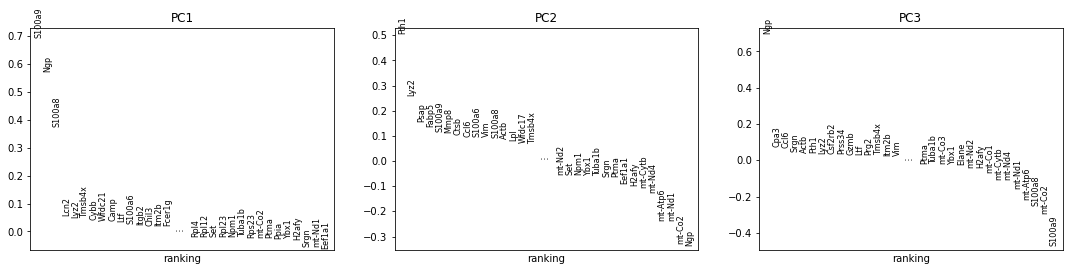

In [27]:
sc.pl.pca_loadings(adata, components = '1,2,3', save="_scanpy.png")

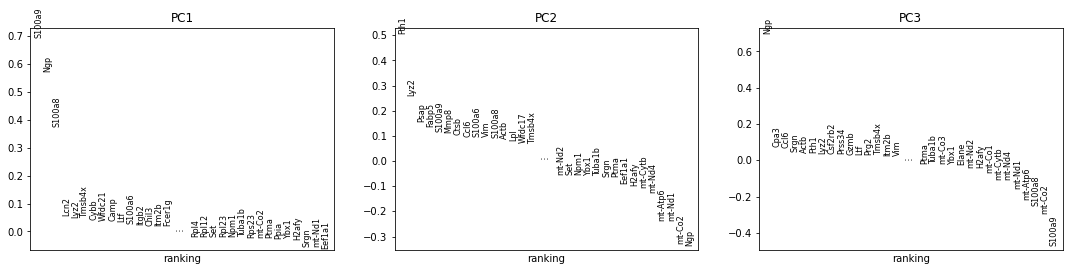

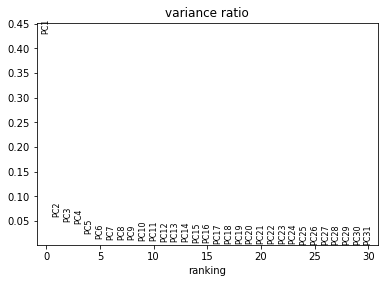

In [28]:
sc.pl.pca_overview(adata, save="_scanpy.png")

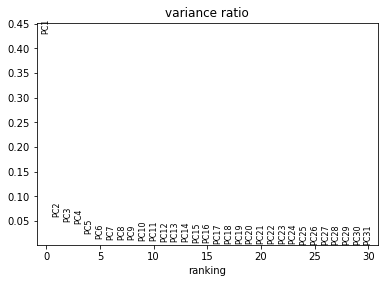

In [29]:
sc.pl.pca_variance_ratio(adata, save="_scanpy.png")

## Load Eigenvectors and Eigenvalues

In [30]:
# Load eigenvalues and eigenvectors
evals_data = np.load(f"{eigdir}/dat_eval.npy")
evecs_data = np.load(f"{eigdir}/dat_evec.npy")

nbins, npca = evals_data.shape
ngenes = evecs_data.shape[2]

print(f"nbins: {nbins}")
print(f"npca: {npca}")
print(f"ngenes: {ngenes}")
print(f"nboot: {nboot}")
print(f"nsamp: {nsamp}")

nbins: 121
npca: 3
ngenes: 25289
nboot: 20
nsamp: 20


In [31]:
# Load bootstrap and nulls
evals_boot = np.zeros([nbins, nboot, npca])
evals_null = np.zeros([nbins, nboot, npca])
for i in range(nbins):
    evals_boot[i] = np.load(f"{eigdir}/boot_eval_t{i}.npy")
    evals_null[i] = np.load(f"{eigdir}/shuf_eval_t{i}.npy")
    

In [32]:
# Compute explained variance ratio
expvar_data = evals_data / np.sum(evals_data, axis=1)[:,None]
expvar_boot = evals_boot / np.sum(evals_boot, axis=2)[:,:,None]
expvar_null = evals_null / np.sum(evals_null, axis=2)[:,:,None]

### Plot evolution of covariance eigenvalues

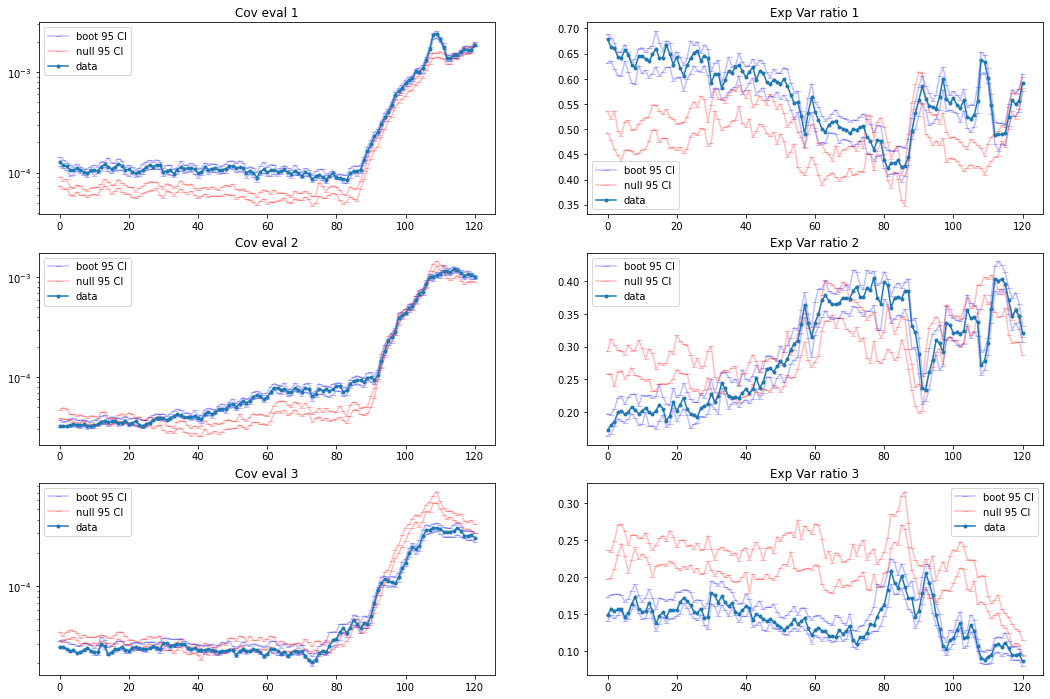

In [33]:
k = npca
fig, axes = plt.subplots(k, 2, figsize=(18,12))

for i in range(k):
    ax = axes[i][0]
    plotter = ax.semilogy
    plotter(np.percentile(evals_boot[:,:,i], 97.5, axis=1), 'b', alpha=0.25, marker='_', label='boot 95 CI');
    plotter(np.percentile(evals_boot[:,:,i], 2.5, axis=1), 'b', alpha=0.25, marker='_');
    plotter(np.percentile(evals_null[:,:,i], 97.5, axis=1), 'r', alpha=0.25, marker='_', label='null 95 CI');
    plotter(np.percentile(evals_null[:,:,i], 2.5, axis=1), 'r', alpha=0.25, marker='_');
    plotter(evals_data[:,i], marker='.', label='data')
    ax.set_title(f"Cov eval {i+1}")
    ax.legend()
    
for i in range(k):
    ax = axes[i][1]
    ax.plot(np.percentile(expvar_boot[:,:,i], 97.5, axis=1), 'b', alpha=0.25, marker='_', label='boot 95 CI');
    ax.plot(np.percentile(expvar_boot[:,:,i], 2.5, axis=1), 'b', alpha=0.25, marker='_');
    ax.plot(np.percentile(expvar_null[:,:,i], 97.5, axis=1), 'r', alpha=0.25, marker='_', label='null 95 CI');
    ax.plot(np.percentile(expvar_null[:,:,i], 2.5, axis=1), 'r', alpha=0.25, marker='_');
    ax.plot(expvar_data[:,i], marker='.', label='data')
    ax.set_title(f"Exp Var ratio {i+1}")
    ax.legend()

plt.savefig(f'{imgdir}/eval_plots.png')

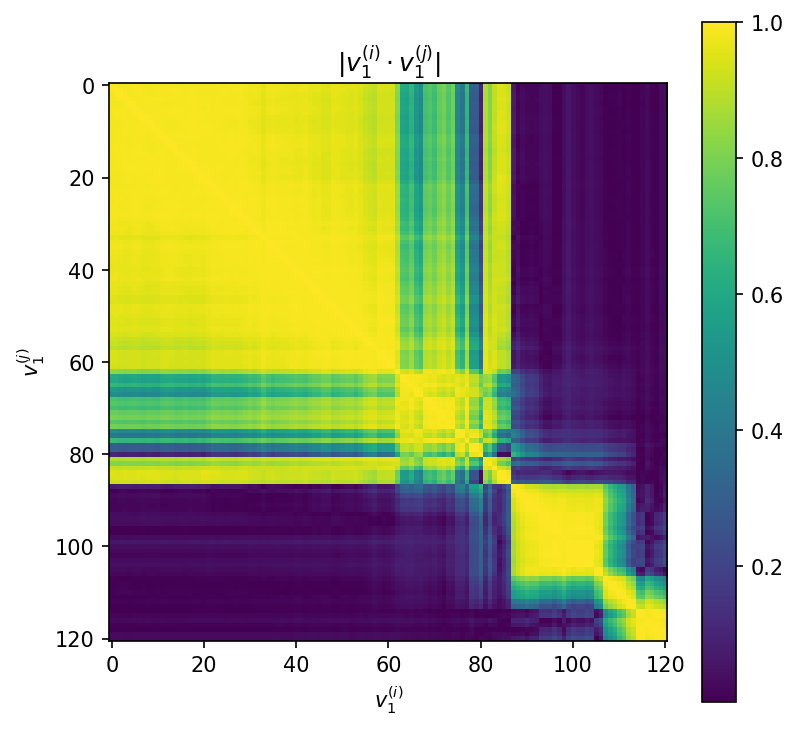

In [34]:
# Location of maximum eigenvalue 1
# take inner product of evect 1 at each pst with every other evect 1 at each pst

evecs_1 = evecs_data[:,0,:]

fig, ax = plt.subplots(1, 1, figsize=(6,6), dpi=150)

im = ax.imshow(np.abs(np.dot(evecs_1, evecs_1.T)))
fig.colorbar(im, orientation='vertical', ax=ax)

ax.set_title(r'$|v_1^{(i)} \cdot v_1^{(j)}|$')
ax.set_xlabel(r'$v_1^{(i)}$')
ax.set_ylabel(r'$v_1^{(j)}$')

plt.savefig(f"{imgdir}/evecs1_inprod_matrix.png")


In [35]:
# max_idx = np.argmax(evals_data[:,0])
# print(f"Max Eval Index: {max_idx}")
# primary_evecs = evecs_data[max_idx]
# primary_evec_1 = primary_evecs[0]
# evecs_data_1 = evecs_data[:,]

## Analysis of Eigenvector Loadings

Interesting Genes (17):
['Eef1a1' 'Elane' 'Fth1' 'Gapdh' 'Ngp' 'Rpl23' 'Rps23' 'S100a8' 'S100a9'
 'Srgn' 'Tuba1b' 'mt-Atp6' 'mt-Co1' 'mt-Co2' 'mt-Cytb' 'mt-Nd1' 'mt-Nd4']


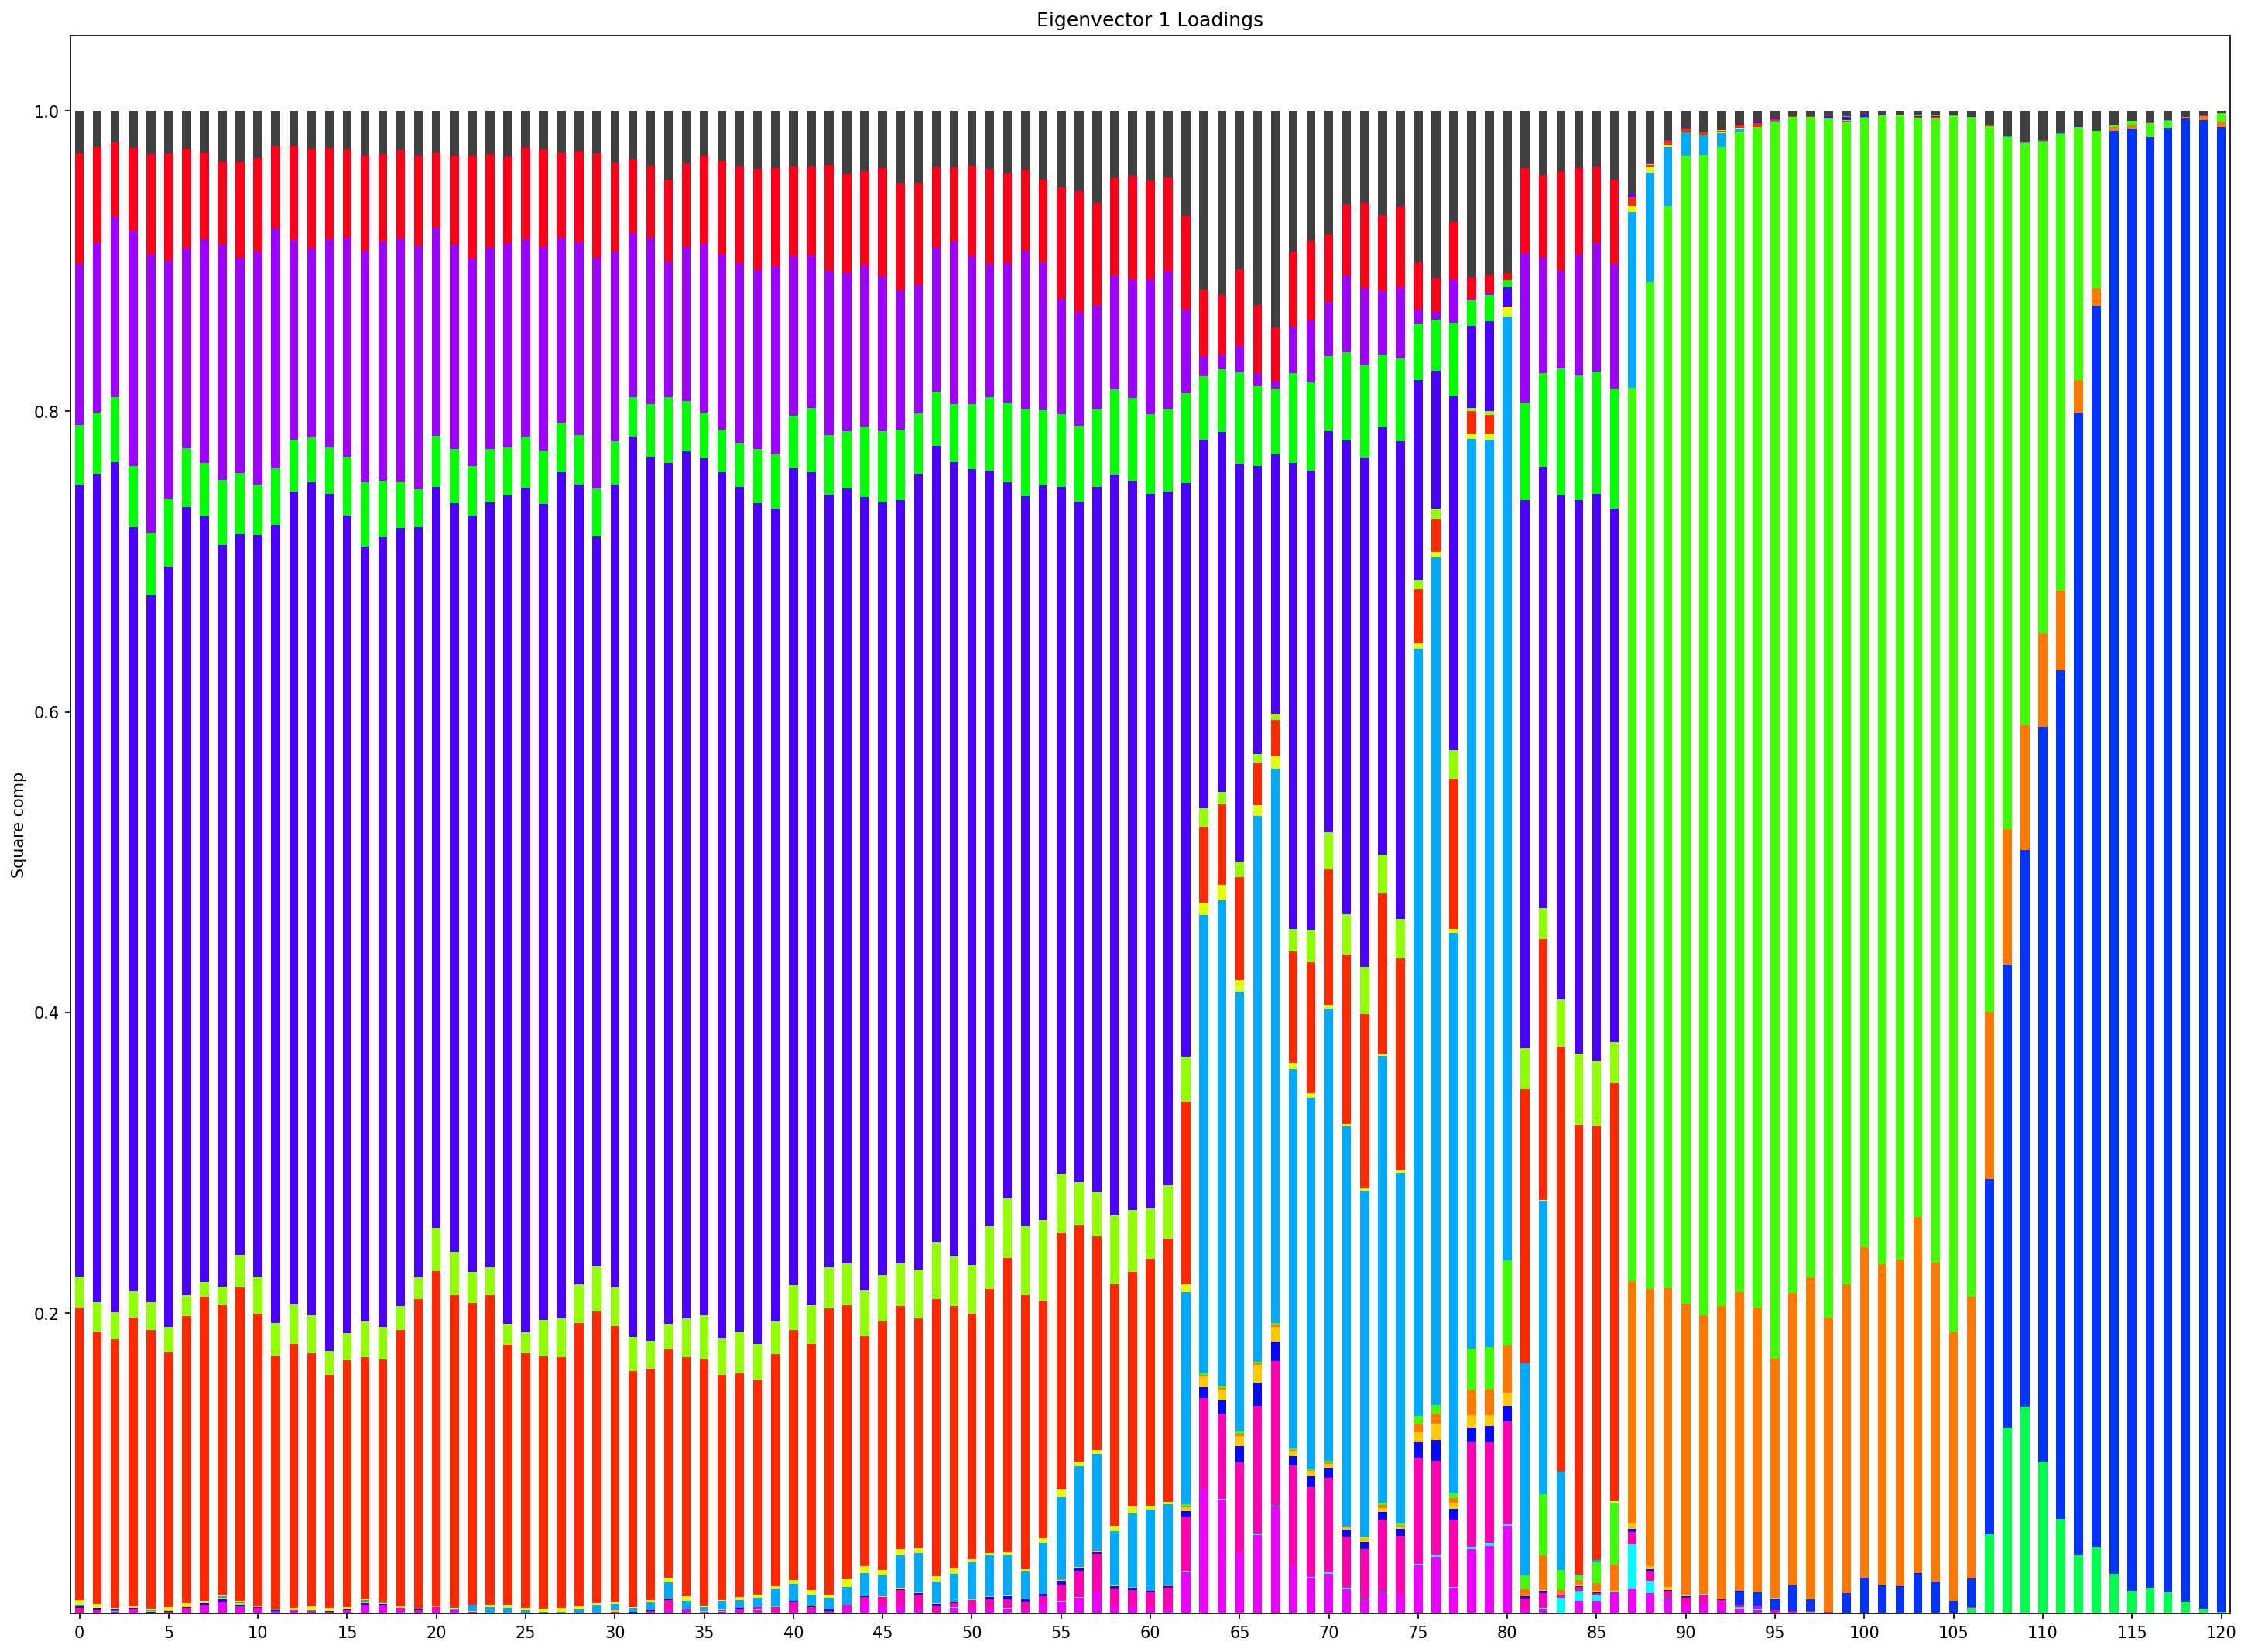

In [36]:
eps = 0.01
idx_subset = list(range(0, 121))
evec_subset = evecs_data[idx_subset, 0, :]
title = "Eigenvector 1 Loadings"
saveas = f"{imgdir}/evec_1_loads_all.png"
data, int_gidxs, int_gnames, cmap = eigenvector_loading_barchart(idx_subset, evec_subset, gnames, eps,
                                        verbose=True, do_table=False, title=title, saveas=saveas, cmap=cmap)

Interesting Genes (29):
['B2m' 'Dlk1' 'Eef1a1' 'Elane' 'Fth1' 'Gapdh' 'Ifitm1' 'Ngp' 'Ptma'
 'Rpl18a' 'Rpl23' 'Rpl27a' 'Rps17' 'Rps23' 'Rps24' 'Rps25' 'S100a8'
 'S100a9' 'Set' 'Srgn' 'Tuba1b' 'Ybx1' 'mt-Atp6' 'mt-Co1' 'mt-Co2'
 'mt-Cytb' 'mt-Nd1' 'mt-Nd2' 'mt-Nd4']


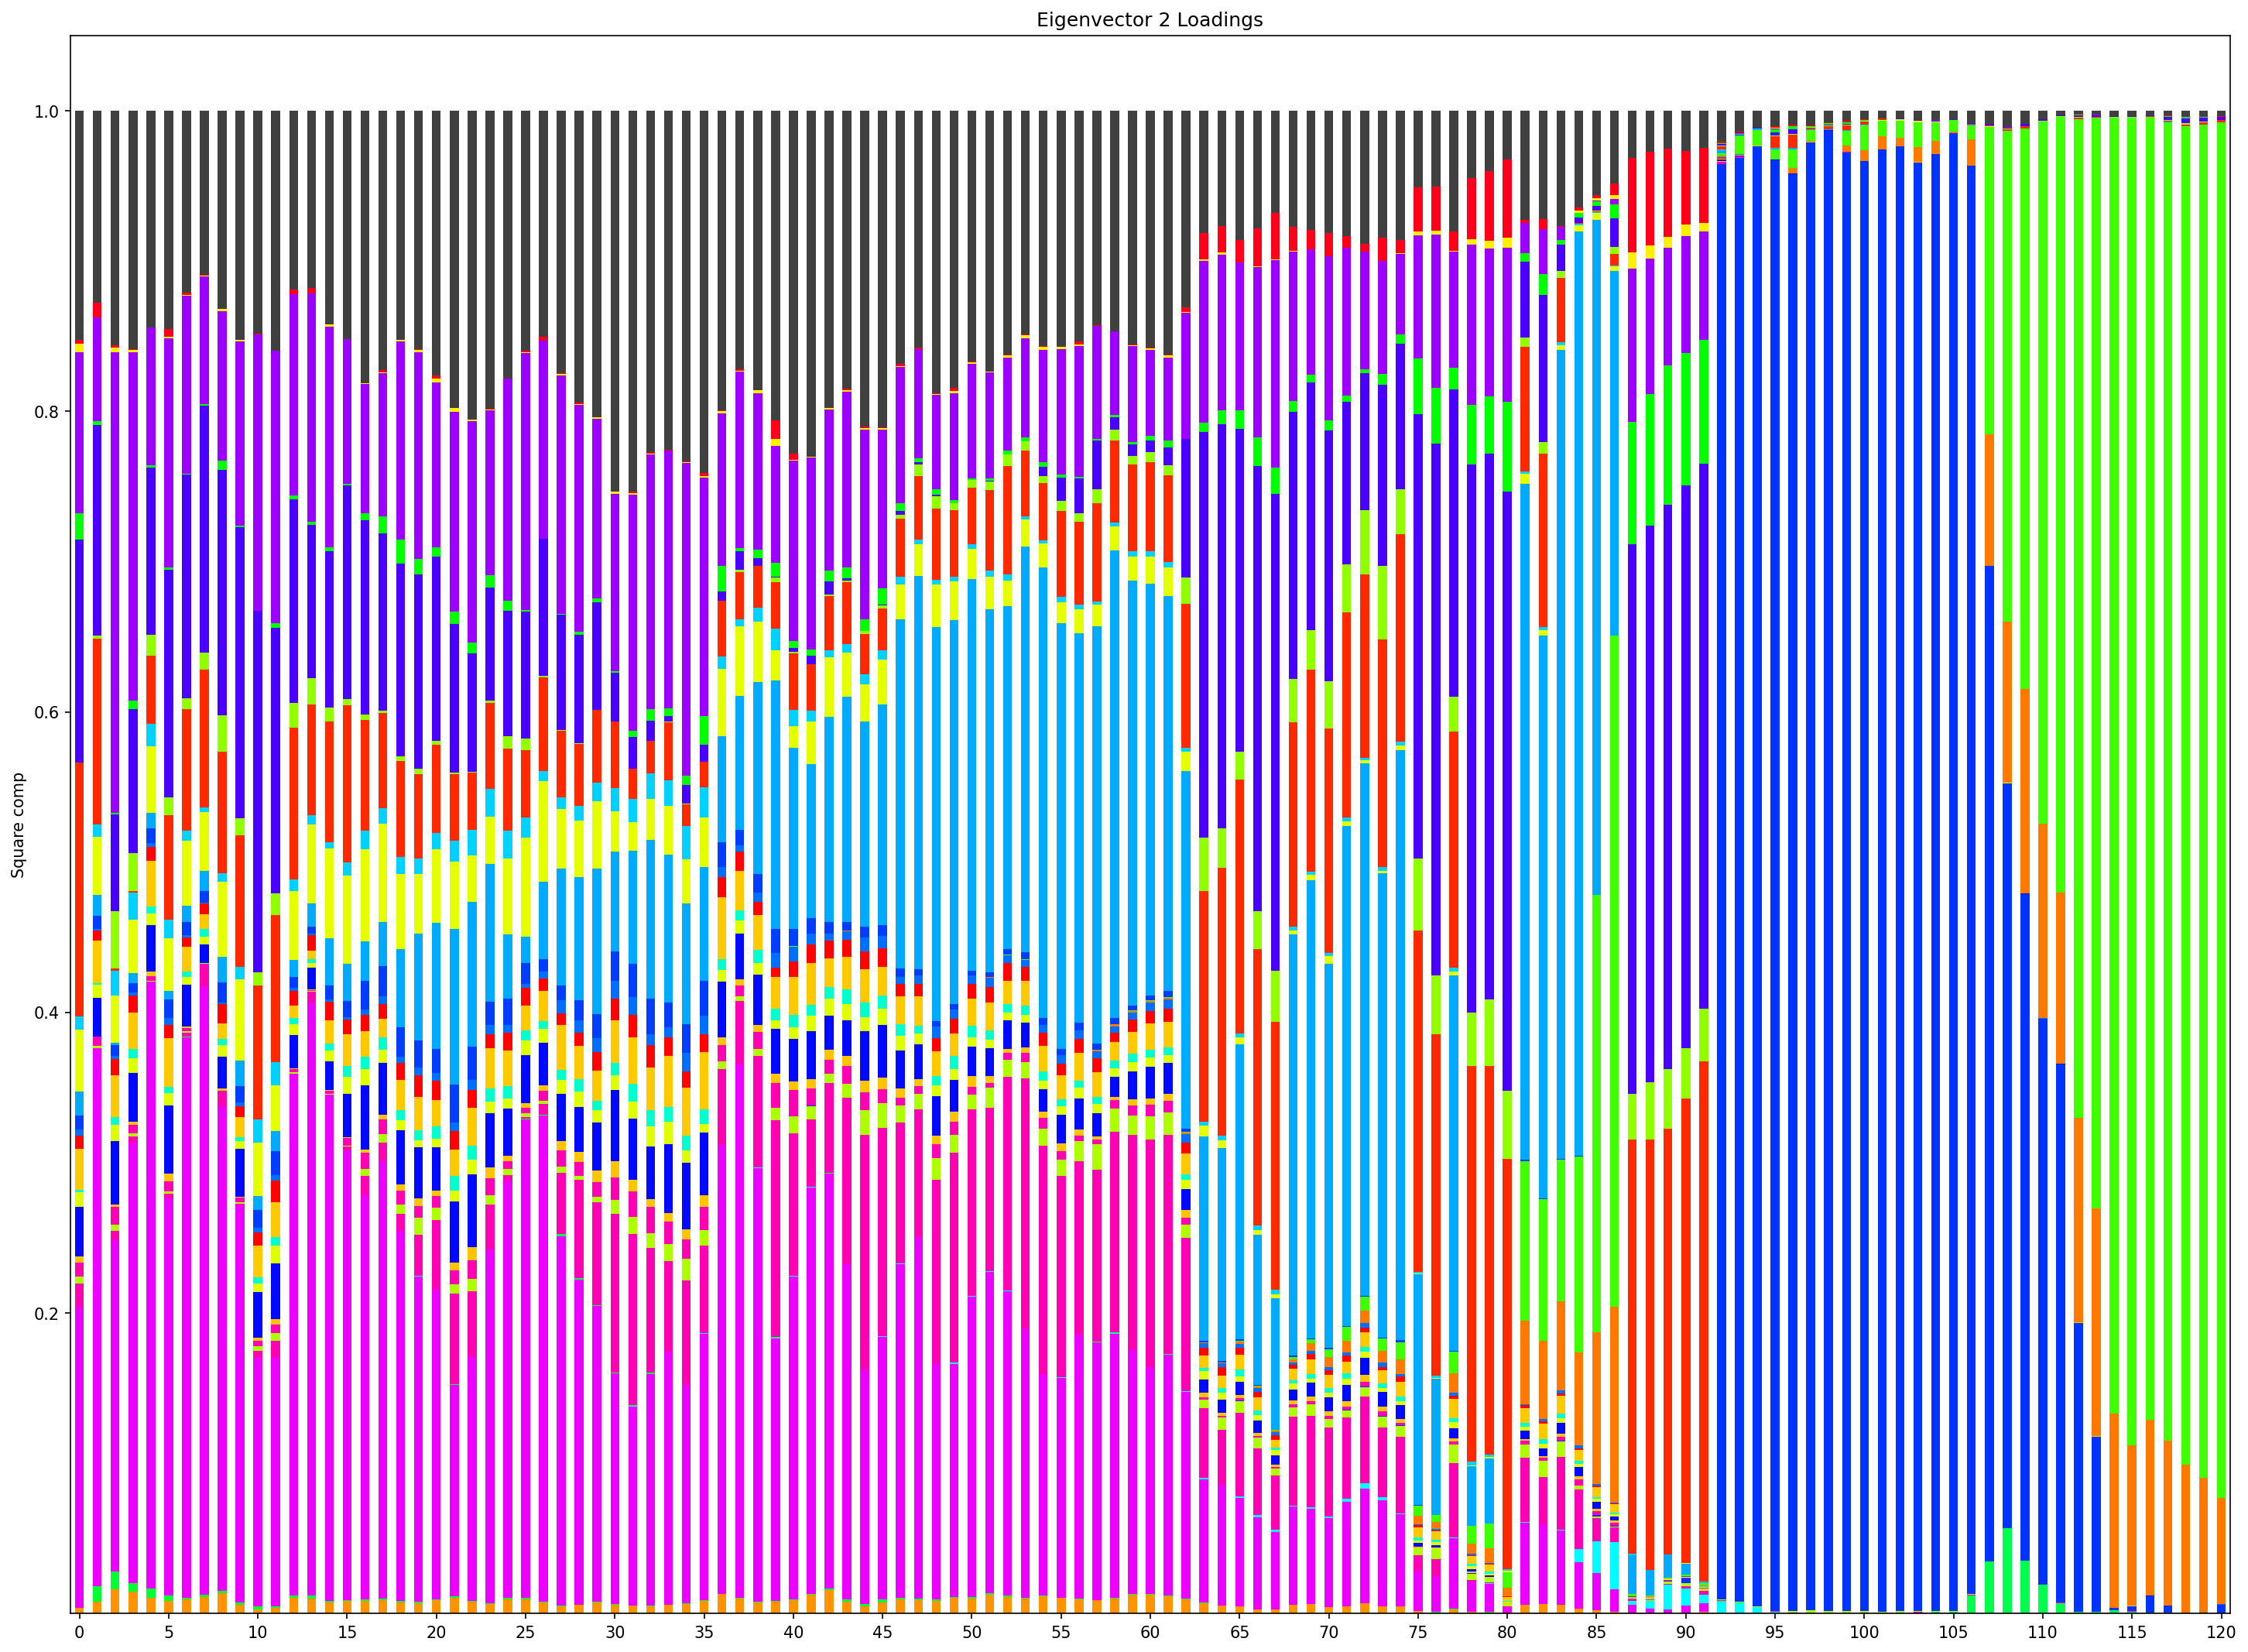

In [37]:
idx_subset = list(range(0, 121))
evec_subset = evecs_data[idx_subset, 1, :]
title = "Eigenvector 2 Loadings"
saveas = f"{imgdir}/evec_2_loads_all.png"
data, int_gidxs, int_gnames, cmap = eigenvector_loading_barchart(idx_subset, evec_subset, gnames, eps,
                                        verbose=True, do_table=False, title=title, saveas=saveas, cmap=cmap)

Interesting Genes (11):
['Eef1a1' 'Gapdh' 'Rpl23' 'Srgn' 'Tuba1b' 'mt-Atp6' 'mt-Co1' 'mt-Co2'
 'mt-Cytb' 'mt-Nd1' 'mt-Nd4']


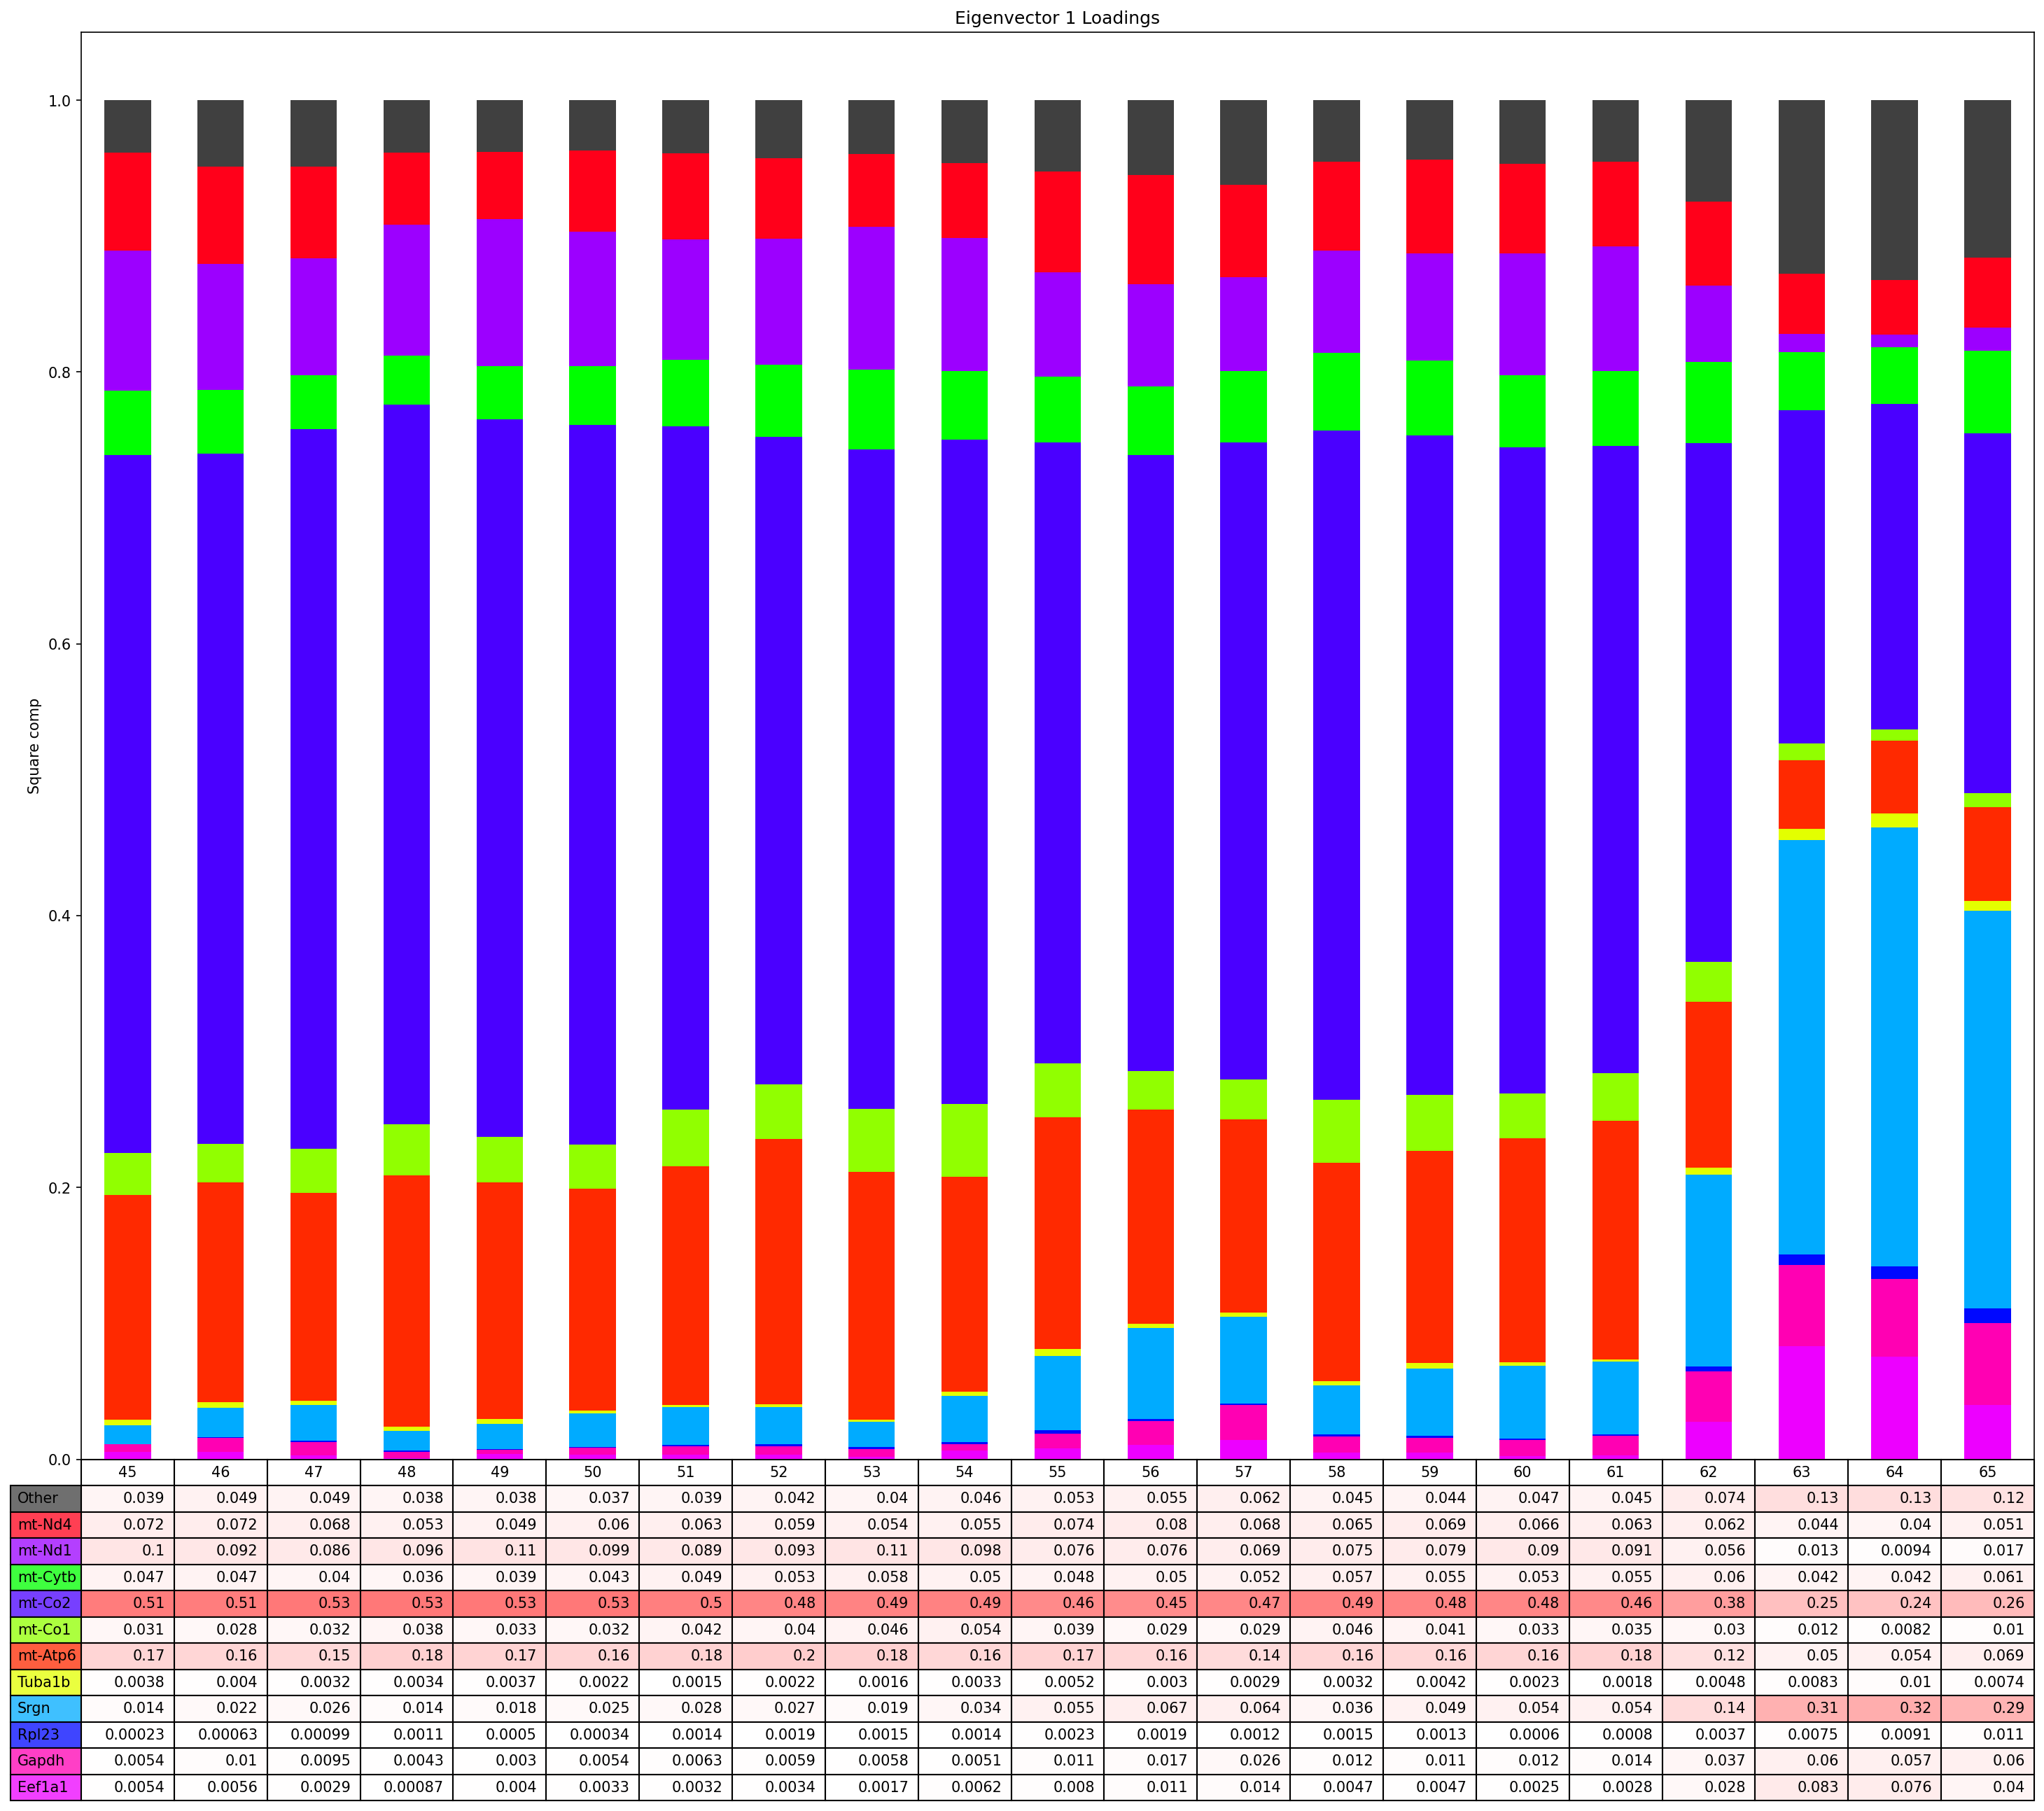

In [38]:
idx_subset = list(range(45, 66))
evec_subset = evecs_data[idx_subset, 0, :]
title = "Eigenvector 1 Loadings"
saveas = f"{imgdir}/evec_1_loads_45_66.png"
data, int_gidxs, int_gnames, cmap = eigenvector_loading_barchart(idx_subset, evec_subset, gnames, eps,
                                        verbose=True, do_table=True, title=title, saveas=saveas, cmap=cmap)

Interesting Genes (14):
['Eef1a1' 'Elane' 'Gapdh' 'Rpl23' 'Rps23' 'S100a8' 'S100a9' 'Srgn'
 'mt-Atp6' 'mt-Co1' 'mt-Co2' 'mt-Cytb' 'mt-Nd1' 'mt-Nd4']


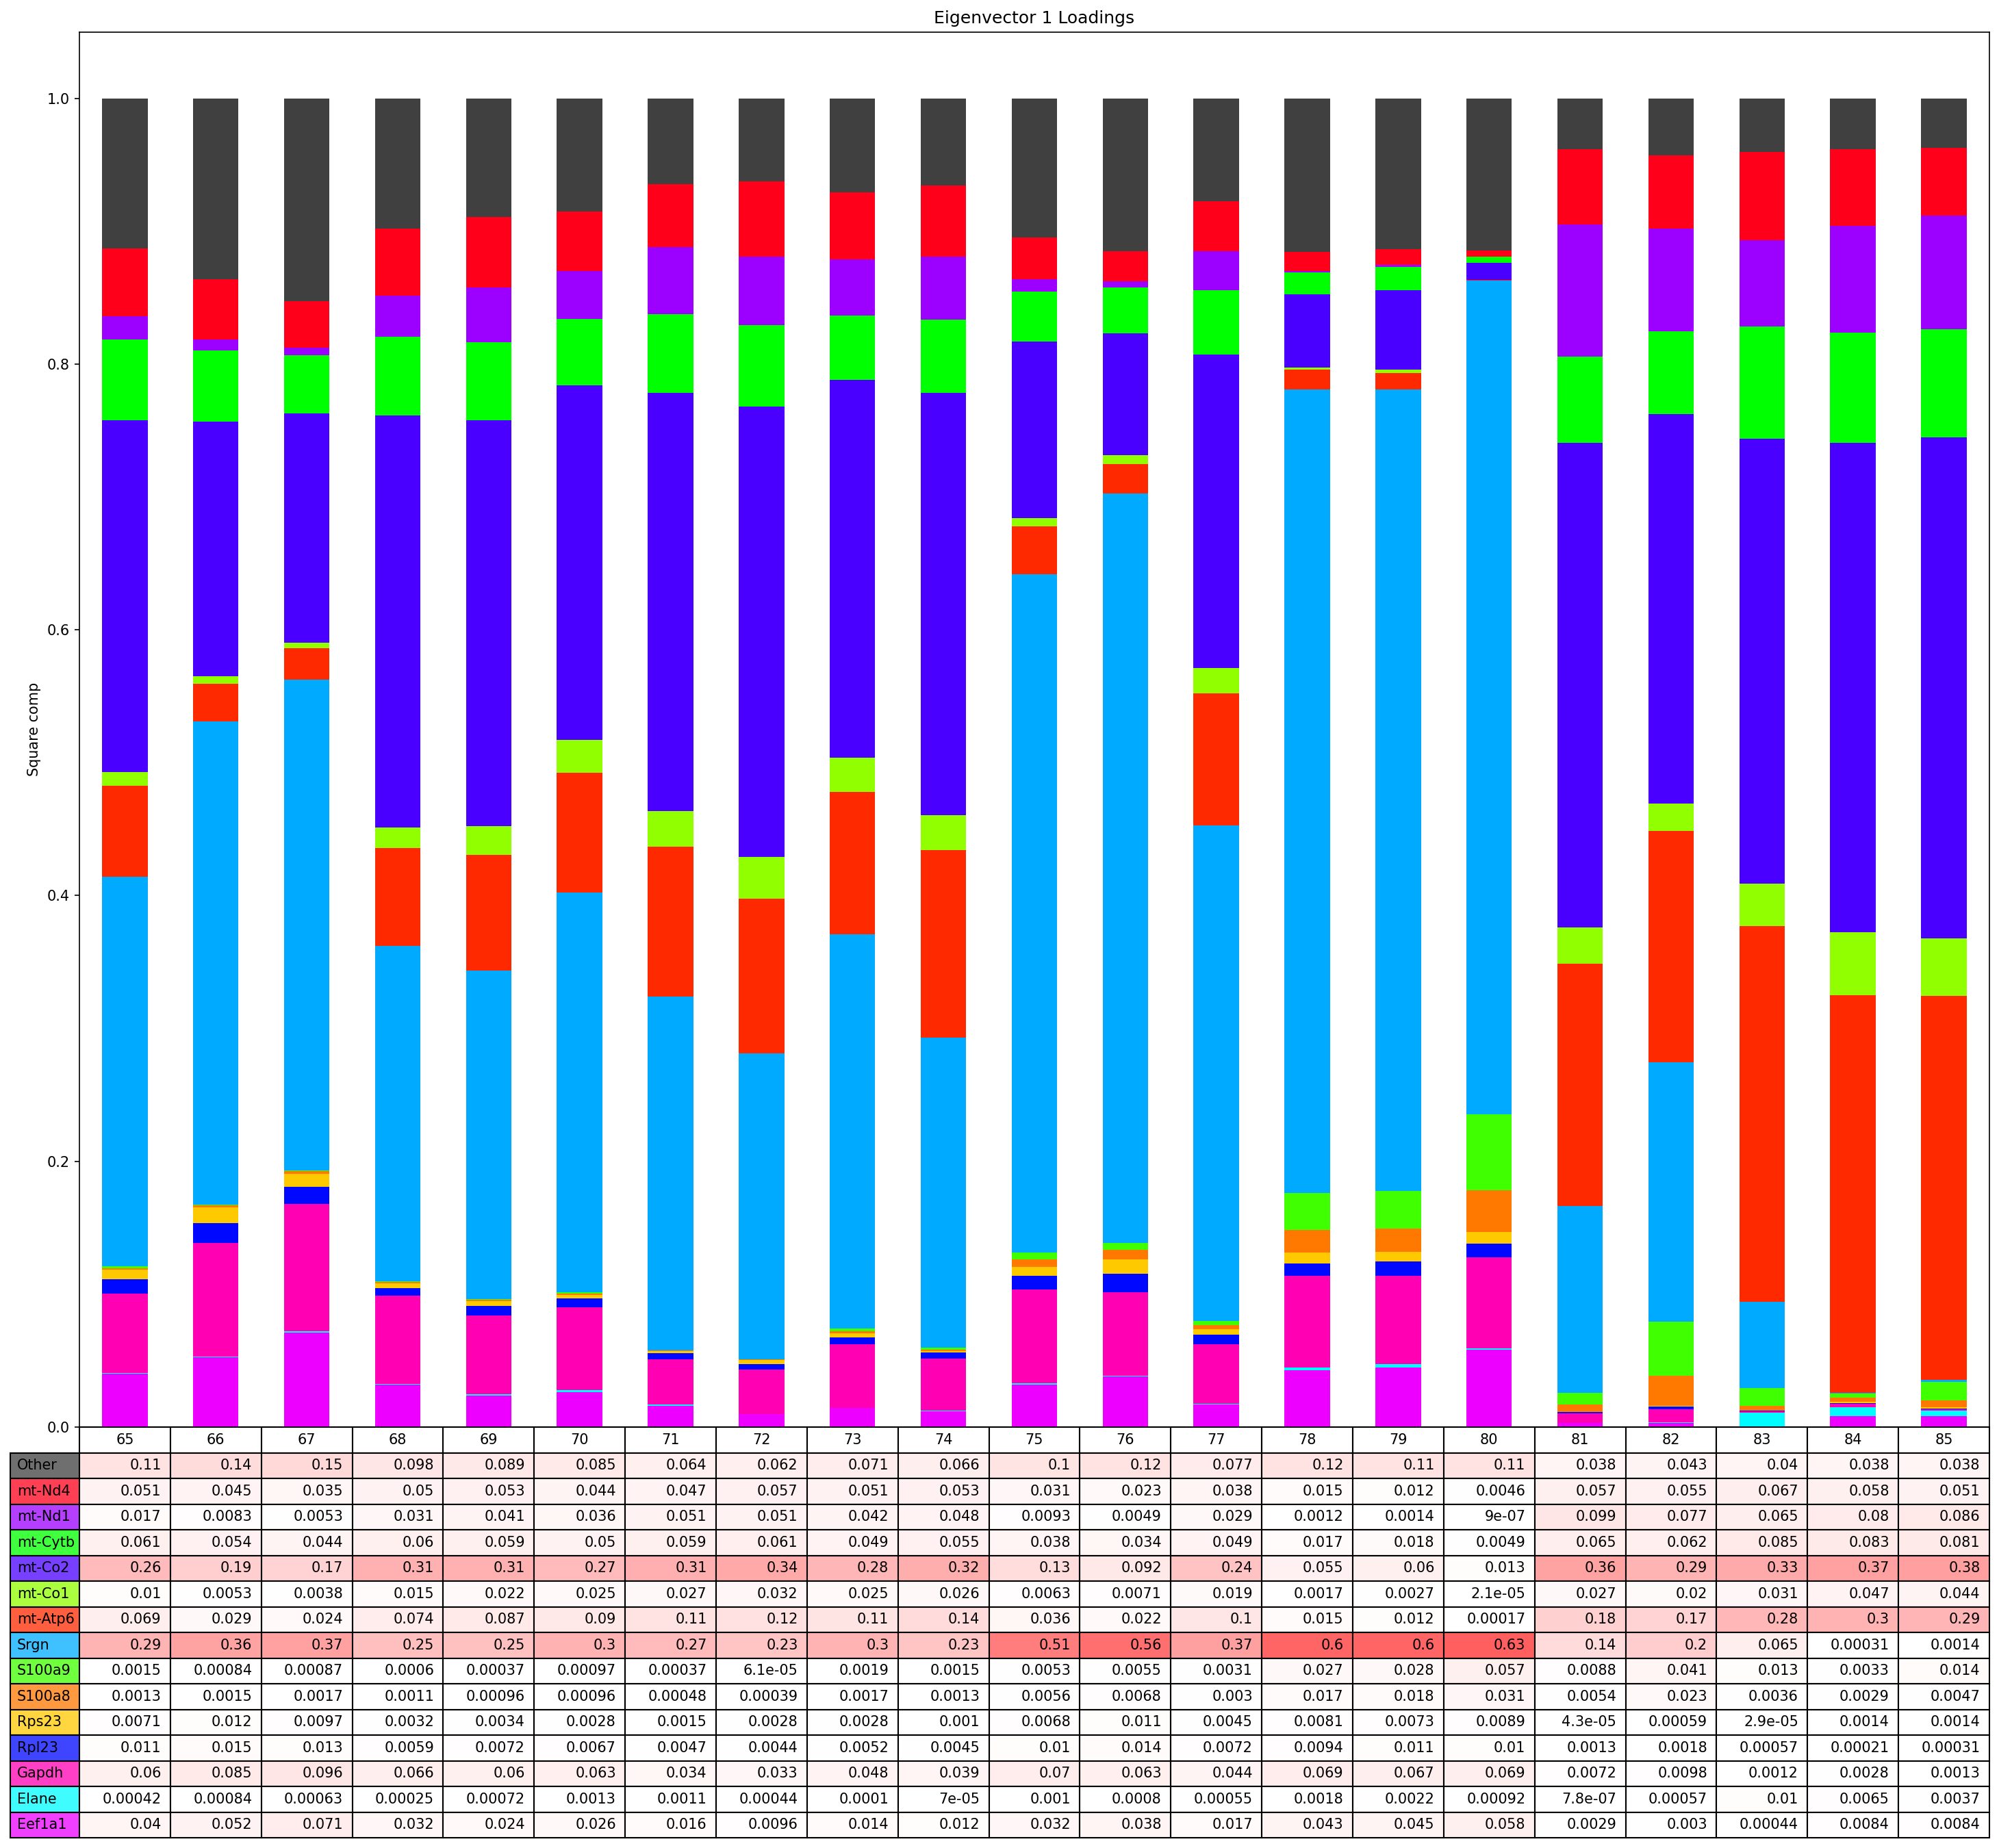

In [39]:
idx_subset = list(range(65, 86))
evec_subset = evecs_data[idx_subset, 0, :]
title = "Eigenvector 1 Loadings"
saveas = f"{imgdir}/evec_1_loads_65_86.png"
data, int_gidxs, int_gnames, cmap = eigenvector_loading_barchart(idx_subset, evec_subset, gnames, eps,
                                        verbose=True, do_table=True, title=title, saveas=saveas, cmap=cmap)

Interesting Genes (15):
['Eef1a1' 'Elane' 'Gapdh' 'Rpl23' 'Rps23' 'S100a8' 'S100a9' 'Srgn'
 'Tuba1b' 'mt-Atp6' 'mt-Co1' 'mt-Co2' 'mt-Cytb' 'mt-Nd1' 'mt-Nd4']


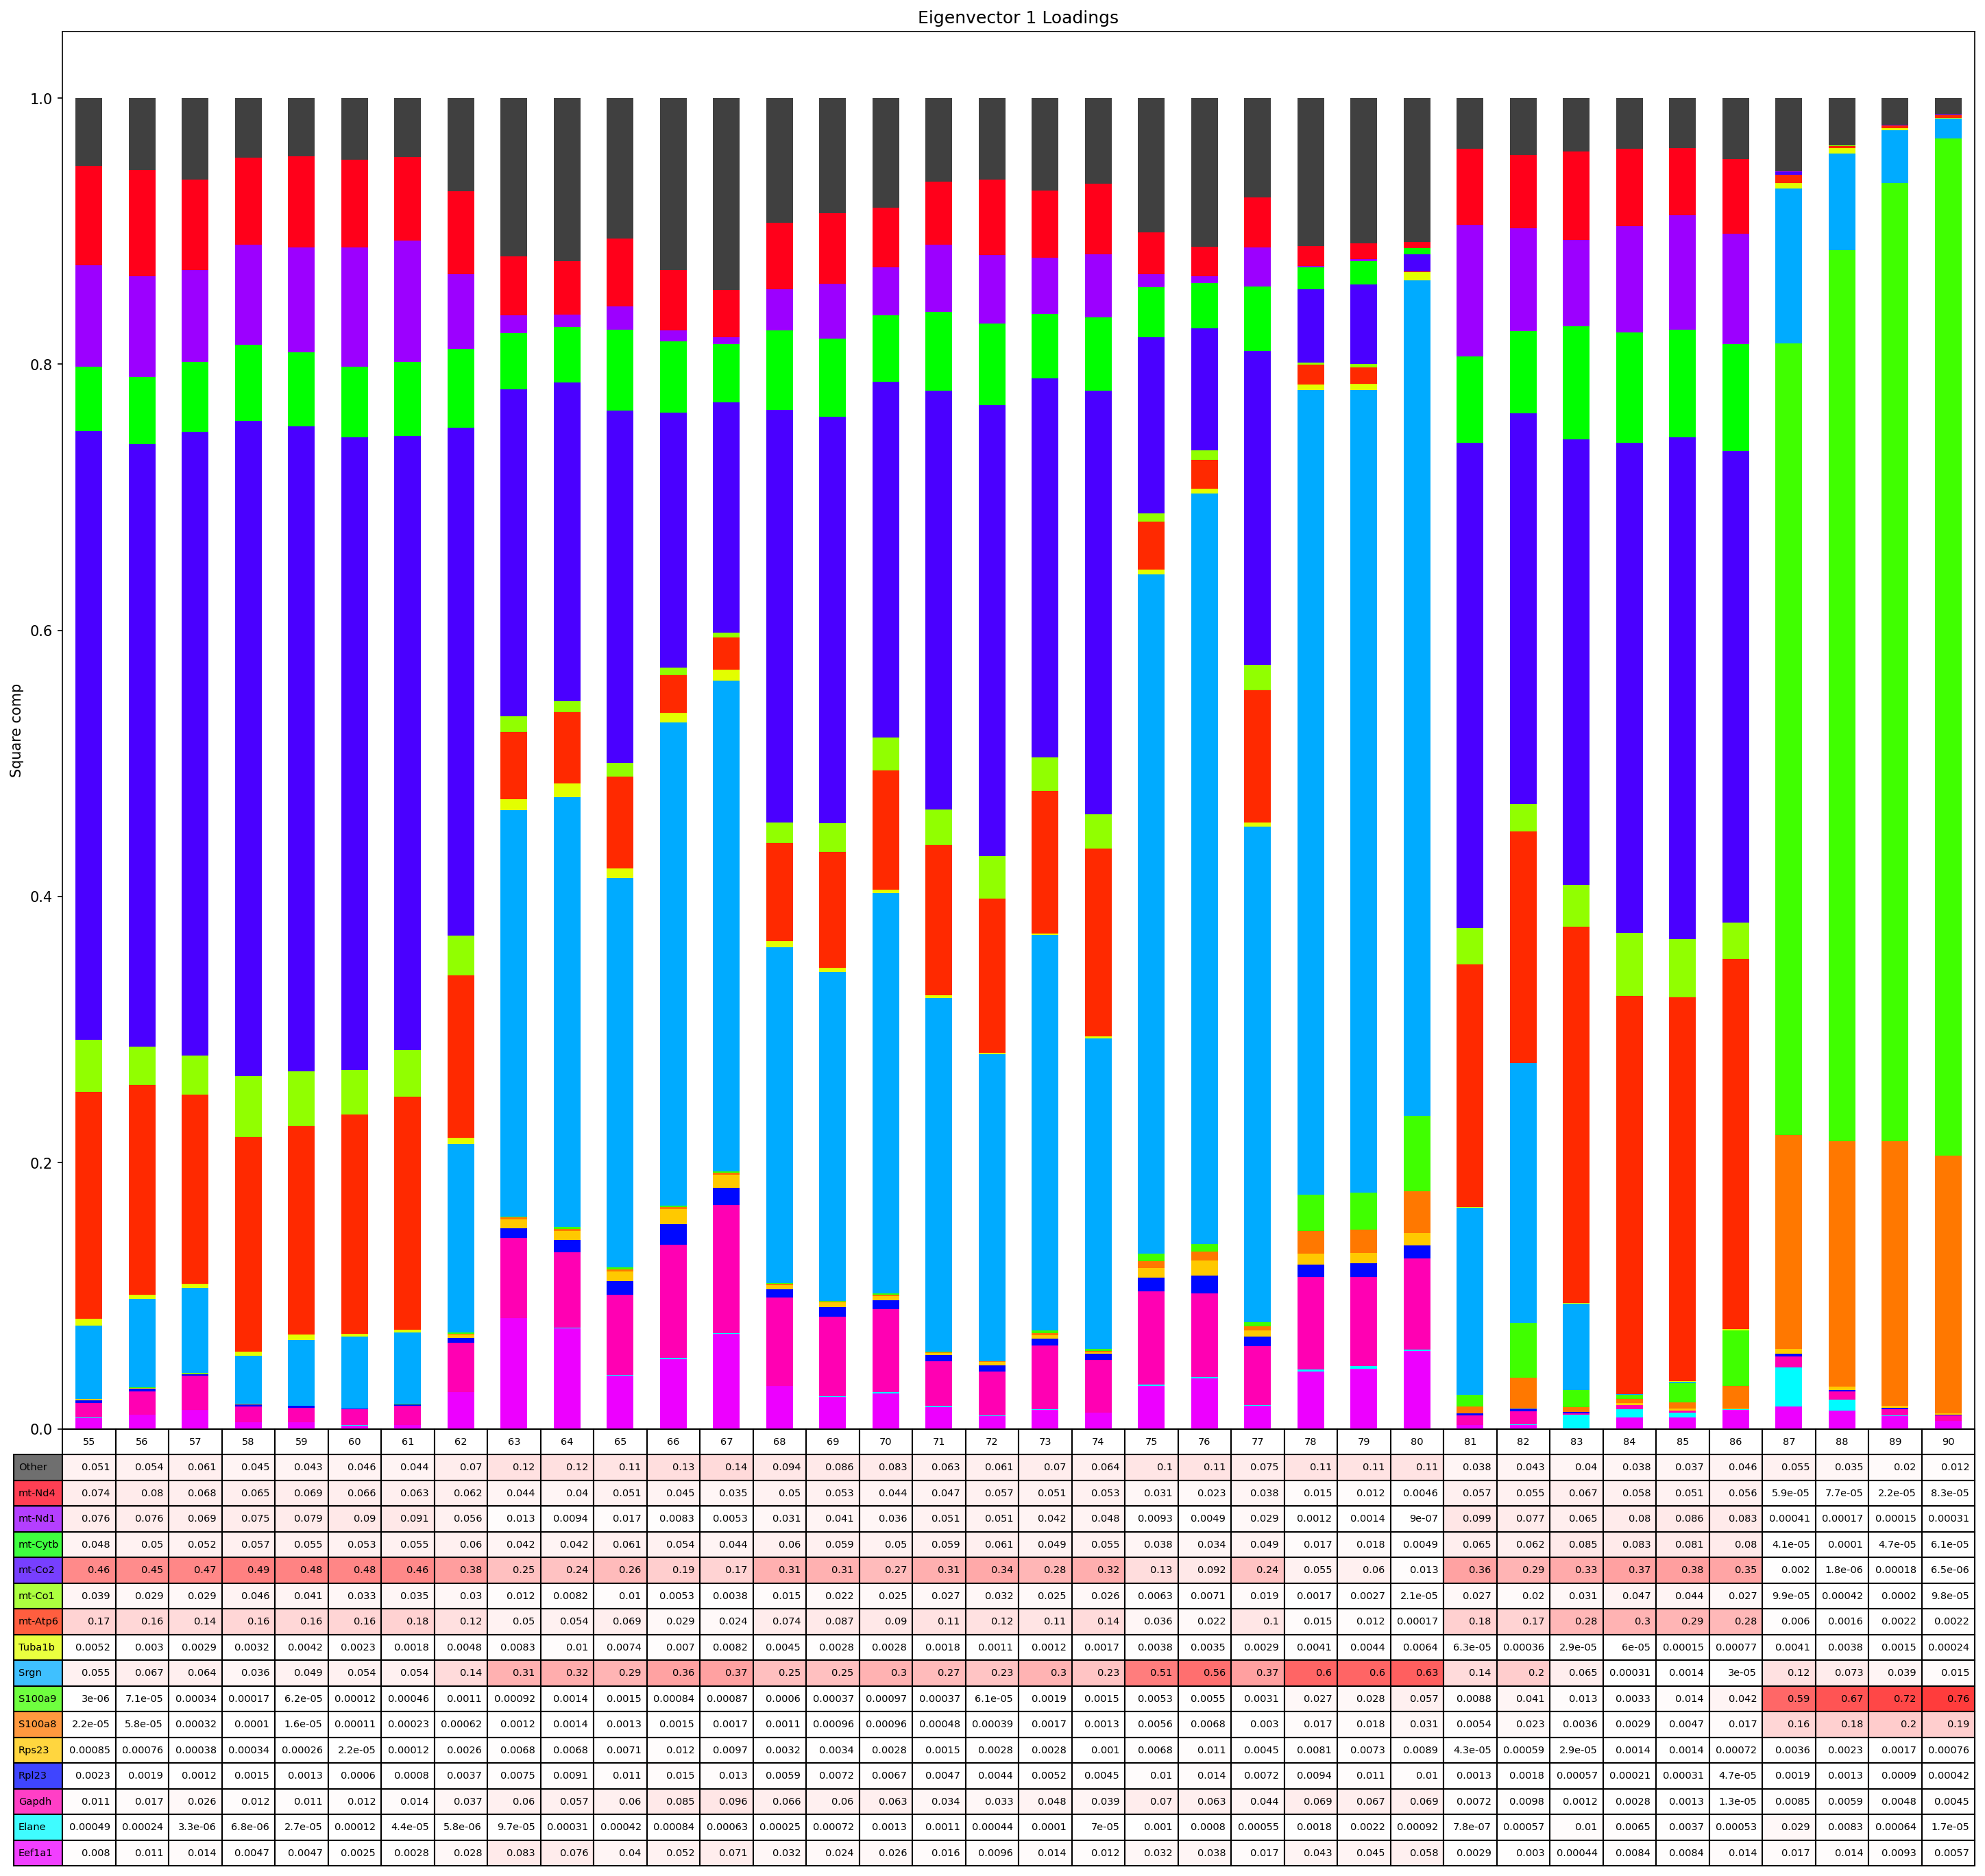

In [40]:
idx_subset = list(range(55, 91))
evec_subset = evecs_data[idx_subset, 0, :]
title = "Eigenvector 1 Loadings"
saveas = f"{imgdir}/evec_1_loads_55_91.png"
data, int_gidxs, int_gnames, cmap = eigenvector_loading_barchart(idx_subset, evec_subset, gnames, eps,
                                        verbose=True, do_table=True, title=title, saveas=saveas, cmap=cmap)

Interesting Genes (4):
['Fth1' 'Ngp' 'S100a8' 'S100a9']


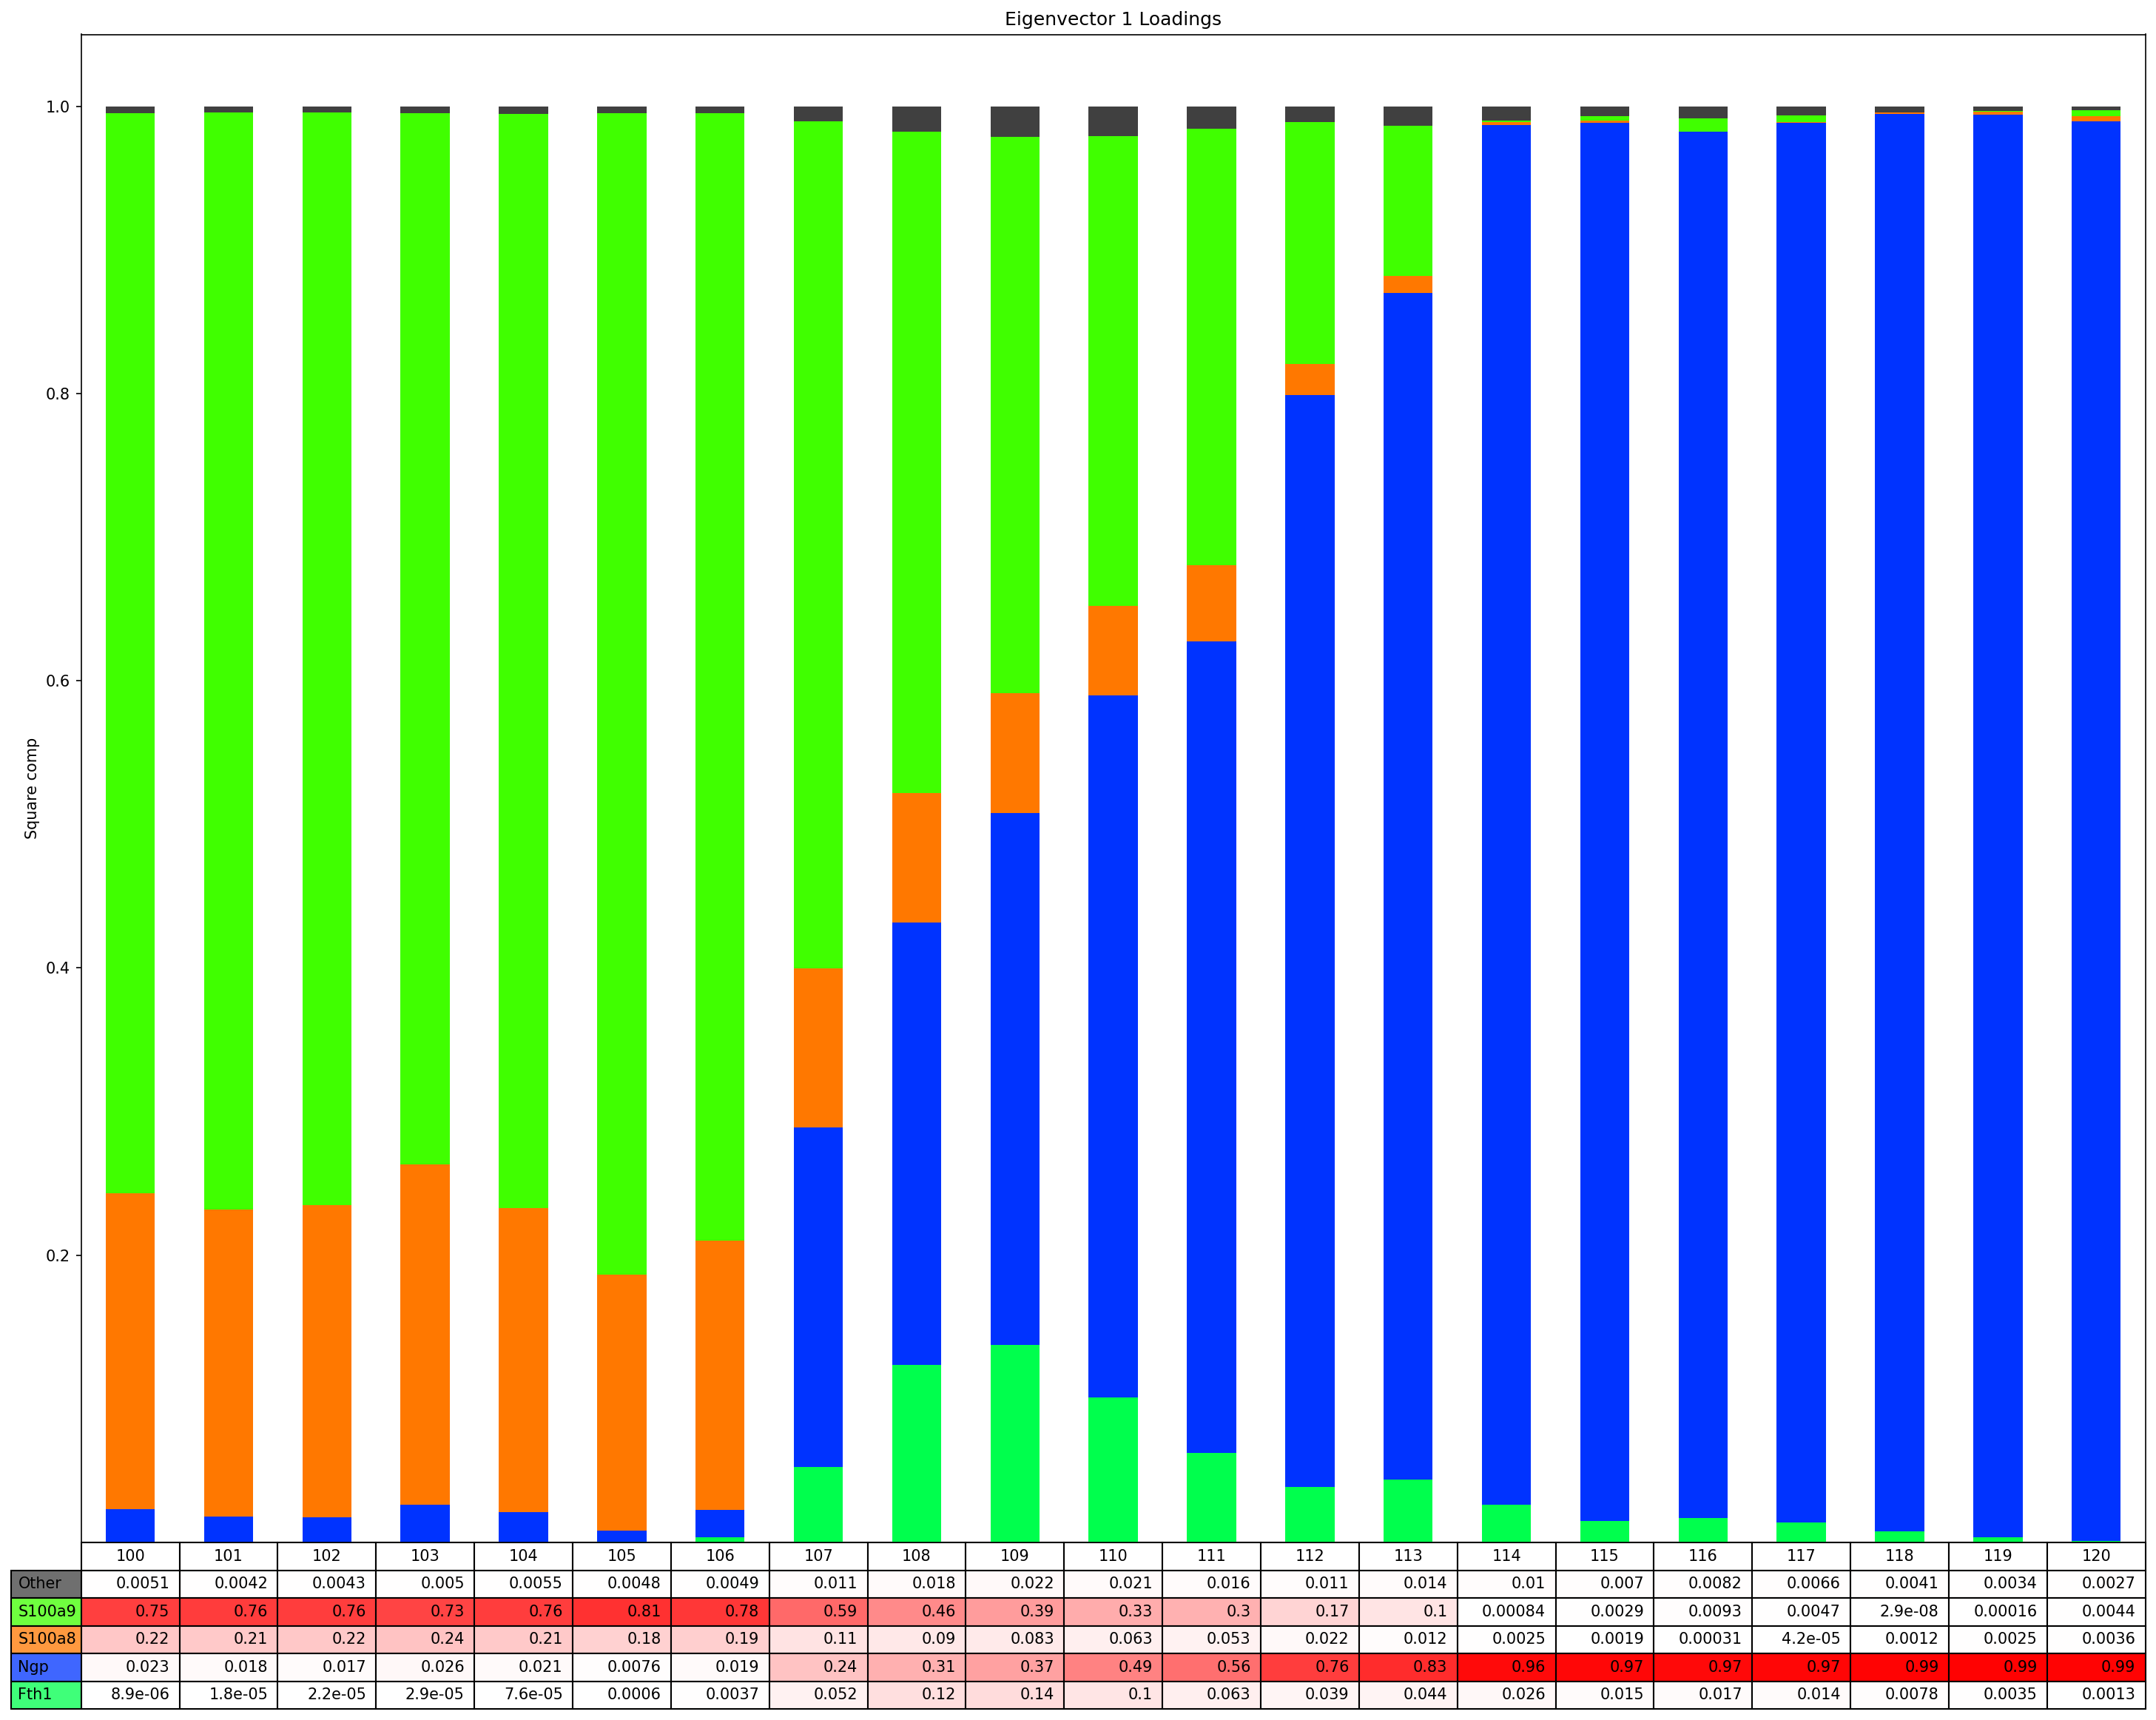

In [41]:
idx_subset = list(range(100, 121))
evec_subset = evecs_data[idx_subset, 0, :]
title = "Eigenvector 1 Loadings"
saveas = f"{imgdir}/evec_1_loads_100_121.png"
data, int_gidxs, int_gnames, cmap = eigenvector_loading_barchart(idx_subset, evec_subset, gnames, eps,
                                        verbose=True, do_table=True, title=title, saveas=saveas, cmap=cmap)